### Workflow

1.  Create a class that inherits from nn.Module and implement the following methods:
    * __init__ (put the convolutional blocks here)
    * forward (this will take a properly formatted T1-w image as input and, once trained, output an approximate T2-w image of the same shape as the input image)
2.  Verify that the forward pass works by running an image from the training set through the network. Check that the input shape is the same as the output shape.

In [1]:
import os
from nifti_dataset import NiftiDataset, RandomCrop3D, ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
input_dir = "/home/nbaranov/projects/04_cv/MedicalImageAnalysis/data/small_data/small/"
f_size = (14,8)

t1_dir = os.path.join(input_dir, 't1')
t2_dir = os.path.join(input_dir, 't2')

In [39]:
ds = NiftiDataset(source_dir=t1_dir,
                  target_dir=t2_dir,
                  transform=[RandomCrop3D(output_size=(64, 64, 90)), ToTensor()],
                  preload=False,
                  )

img1, img2 = ds.__getitem__(0)
print(img1.shape)

torch.Size([1, 64, 64, 90])


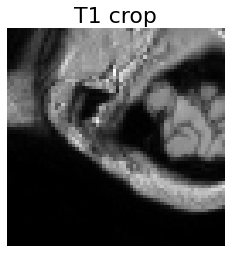

In [40]:
plt.imshow(img1.squeeze(0)[:,:,15], cmap='gray')
plt.title('T1 crop', fontsize=22)
plt.axis('off');

d_out = (d_in -1) * stride[3] - 2 * padding[3] + dilation *(kernel_size - 1) + output_padding[3] + 1

In [101]:
d_out = (23 - 1) * 2 - 2 * 1 + 1 * (3 - 1) + 1 + 1
d_out

46

In [102]:
d_out2 = (d_out - 1) * 2 - 2 * 2 + 1 * (3 - 1) + 1 + 1
d_out2

90

In [91]:
from torch import nn


class SimpleEncDec(nn.Module):
    """
    Simple encoder-decoder net
    """
    def __init__(self, in_channels: int = 1):
        super().__init__()
        self.encoder = nn.Sequential(
            self.encoder_block(in_channels=in_channels,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               output_size=(64//2, 64//2, 90//2)
                               ),
            self.encoder_block(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,
                               output_size=(32//2, 32//2, 45//2+1)
                               )
        )
        self.decoder = nn.Sequential(
            self.decoder_block(in_channels=32,
                               out_channels=16,
                               kernel_size=3,
                               stride=2,
                               padding=(1, 1, 1),
                               output_padding=(1, 1, 1)
                               ),
            self.decoder_block(in_channels=16,
                               out_channels=1,
                               kernel_size=3,
                               stride=2,
                               padding=(1, 1, 2),
                               output_padding=(1, 1, 1)
                               )
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encoder_block(self, in_channels, out_channels, kernel_size, stride, output_size):
        return nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d(output_size),
        )
    def decoder_block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, padding=padding, output_padding=output_padding),
            nn.ReLU(),
        )

In [92]:
convEncNet = SimpleEncDec()
print(convEncNet)

SimpleEncDec(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): ReLU()
      (2): AdaptiveMaxPool3d(output_size=(32, 32, 45))
    )
    (1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): ReLU()
      (2): AdaptiveMaxPool3d(output_size=(16, 16, 23))
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose3d(16, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 2), output_padding=(1, 1, 1))
      (1): ReLU()
    )
  )
)


In [94]:
input_img = img1.float().unsqueeze(0)

output = convEncNet(input_img)
assert input_img.shape == output.shape
print(output.shape)

torch.Size([1, 1, 64, 64, 90])
